## Regional Satellite / WRF-Chem comparison script

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import ticker

import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# loads column and lat/lon data, and converts to panda array.
#    This includes copying the time index to our model data, because
#    I had not added this to the model netcdf files when creating them.
def load_create_dataframe(sat_datadask,model_datadask):

    sat_col_data = sat_datadask.column.copy(deep=True)
    sat_error_data = sat_datadask.error.copy(deep=True)
    sat_vprof_data = sat_datadask.VertProf.copy(deep=True)
    lat_data = sat_datadask.latitude.copy(deep=True)
    lon_data = sat_datadask.longitude.copy(deep=True)
    
    # convert from xarray to pandas dataframe
    cold = sat_col_data.to_dataframe()
    errd = sat_error_data.to_dataframe()
    verd = sat_vprof_data.to_dataframe()
    latd = lat_data.to_dataframe()
    lond = lon_data.to_dataframe()
 
    # pull out time from the satellite data
    sat_time_data = satellite_datadask.time.copy(deep=True)
    sat_time = sat_time_data.to_dataframe().reset_index(drop=True)
    
    # load and add time to the model data
    model_data = model_datadask.nh3.copy(deep=True)
    model = model_data.to_dataframe().reset_index(drop=True)
    model_time = pd.concat([sat_time,model],axis=1,sort=False)
    modd = model_time.set_index('time')
    
    result = pd.concat([modd,cold,errd,verd,latd,lond], axis=1, sort=False)

    return result

#### Load satellite and model data

The 'time' index in the satellite data is 'UTC time of acquisition', in units 'HHMMSS.ms', so I think that we need to be careful to only load data for a single day at a time for this processing. Otherwise the coordinate system could become confused by duplicate values for each day. This doesn't matter for the global satellite data plots, but for this work we are merging model and satellite data, and so we need to be more careful with indexing.

In [35]:
satellite_file_path = '/Volumes/Work_Space/Clearflo/satellite_data/'
model_file_path = '/Volumes/Work_Space/Clearflo/model_column_data/'
date_string = '20120810_*'
satellite_datadask = xr.open_mfdataset(satellite_file_path+'nh3nn_v2_2_'+date_string+'.nc')
model_datadask = xr.open_mfdataset(model_file_path+'Ammonia_Column_'+date_string+'_gasphase_chemistry.nc')

In [36]:
work_data = load_create_dataframe(satellite_datadask,model_datadask)

/Users/lowe/anaconda2/envs/iris/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [40]:
clean_data = work_data.dropna()
#clean_data = work_data.dropna()
cd2 = clean_data.reset_index()
cd_all = cd2.set_index(['VertProf','time'])
cd_land = cd_all.loc(axis=0)[1]
cd_sea  = cd_all.loc(axis=0)[0]

### Data plotting

I have created 3 sets of data:
* cd_all:  all co-located model/satellite data
* cd_land: all columns flagged as land-based
* cd_sea:  all columns flagged as sea-based

There's a lot of satellite data which have negative values - I've left these in for the moment (though they get removed by the log plot anyway).

There's a lot more variation in the satellite data, and it does seem to go higher than the model data (with not a great deal of correlation between the two).

To do: 
* addition of error bars for satellite data
* filter for zenith angle of satellite measurements?

(0, 4e+16)

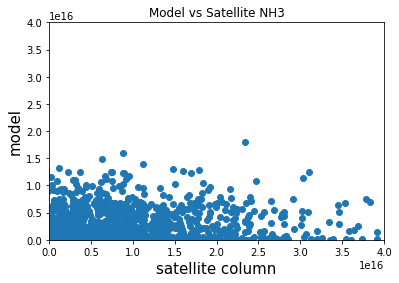

In [52]:
cd_plot = cd_land
fig, ax = plt.subplots()
ax.scatter(cd_plot.column, cd_plot.nh3)
ax.set_xlabel(r'satellite column', fontsize=15)
ax.set_ylabel(r'model', fontsize=15)
ax.set_title('Model vs Satellite NH3')
#ax.set_xlim(-2e16,4e16)
#ax.set_ylim(-2e16,4e16)
ax.set_xlim(0,4e16)
ax.set_ylim(0,4e16)


(1000000000000.0, 1e+17)

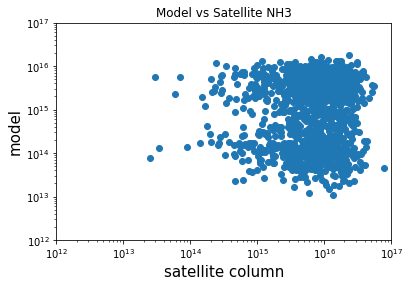

In [51]:
cd_plot = cd_land
fig, ax = plt.subplots()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.scatter(cd_plot.column, cd_plot.nh3)
ax.set_xlabel(r'satellite column', fontsize=15)
ax.set_ylabel(r'model', fontsize=15)
ax.set_title('Model vs Satellite NH3')
ax.set_xlim(1e12,1e17)
ax.set_ylim(1e12,1e17)


In [31]:
satellite_datadask.VertProf.long_name

'Vertical profile used in the retrieval procedure. 0= Sea profile, 1= Land profile, 2= PBL height'